In [166]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [15]:
filenames = ['Whole_WY_{0}.csv'.format(year) for year in range(1971,2020)]
dfs = [pd.read_csv(filename) for filename in filenames]

In [78]:
def tweak_sierra(sierra):
    return (sierra
            .rename(columns=lambda c: c.lower().replace(' ','_'))
            .assign(total_precip_mm = lambda df_: df_['24-hour_total_precip_(mm)']
                    .replace({'T':'0.001', '--':np.nan})
                    .astype('float16'),
                    date = lambda df_: pd.to_datetime(df_['date']),
                    season_total_precip_mm = lambda df_: df_['season_total_precip_(mm)']
                    .replace({'T':'0.001', '--':np.nan})
                    .astype('float16'),
                    new_snow_cm = lambda df_: df_['new_snow_(cm)']
                    .replace({'T':'0.001', '--':0,'.':0})
                    .astype('float16'),
                    snowpack_depth_cm = lambda df_: df_['snowpack_depth_(cm)']
                    .replace({'T':'0.001', '--':np.nan, 920:92})
                    .astype('float16'),
                    snow_water_equivalent_cm = lambda df_: df_['snow_water_equivalent_(cm)']
                    .replace({'T':'0.001', '--':np.nan,"0'0":0,'1401':14,'355.6':55.6})
                    .astype('float16'),
                    air_temp_max_f = lambda df_: df_['air_temp_max_(c)']
                    .replace({'--':np.nan}).astype('float16')*9/5+32,
                    air_temp_min_f = lambda df_: df_['air_temp_min_(c)']
                    .replace({'--':np.nan,87:8}).astype('float16')*9/5+32,
                    season_total_snow_cm = lambda df_: df_['season_total_snow_(cm)']
                    .replace({'T':'0.001', '--':np.nan})
                    .astype('float16'),
                    day_of_year = lambda df_: df_['date'].dt.dayofyear
                   )
            .drop(columns=['%_of_precip_as_snow','%_of_precip_as_rain','remarks',
                           '24-hour_total_precip_(mm)','season_total_precip_(mm)',
                           'new_snow_(cm)','snowpack_depth_(cm)','snow_water_equivalent_(cm)',
                           'air_temp_max_(c)','air_temp_min_(c)','season_total_snow_(cm)'])
           )

In [79]:
cleaned_dfs = [tweak_sierra(df) for df in dfs]

In [89]:
summed = 0
for df in dfs:
    summed = summed + sys.getsizeof(df)
summed

7270949

In [90]:
summed = 0
for df in cleaned_dfs:
    summed = summed + sys.getsizeof(df)
summed

579760

In [80]:
for i in range(len(dfs)):
    print(cleaned_dfs[i].dtypes)
    print()

date                        datetime64[ns]
total_precip_mm                    float16
season_total_precip_mm             float16
new_snow_cm                        float16
snowpack_depth_cm                  float16
snow_water_equivalent_cm           float16
air_temp_max_f                     float16
air_temp_min_f                     float16
season_total_snow_cm               float16
day_of_year                          int64
dtype: object

date                        datetime64[ns]
total_precip_mm                    float16
season_total_precip_mm             float16
new_snow_cm                        float16
snowpack_depth_cm                  float16
snow_water_equivalent_cm           float16
air_temp_max_f                     float16
air_temp_min_f                     float16
season_total_snow_cm               float16
day_of_year                          int64
dtype: object

date                        datetime64[ns]
total_precip_mm                    float16
season_total_precip_mm  

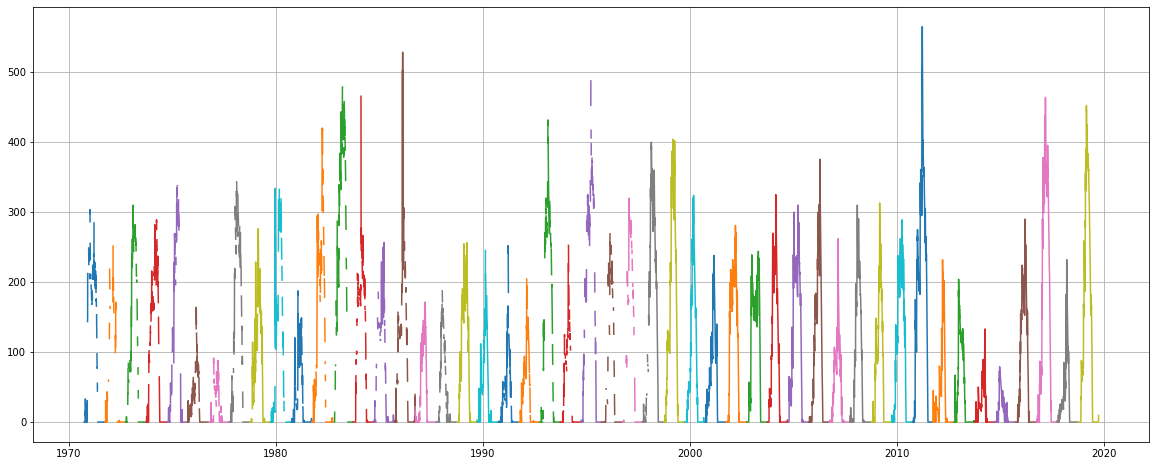

In [46]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):
    plt.plot(cleaned_dfs[i]['date'],cleaned_dfs[i]['snowpack_depth_cm'])
plt.grid()

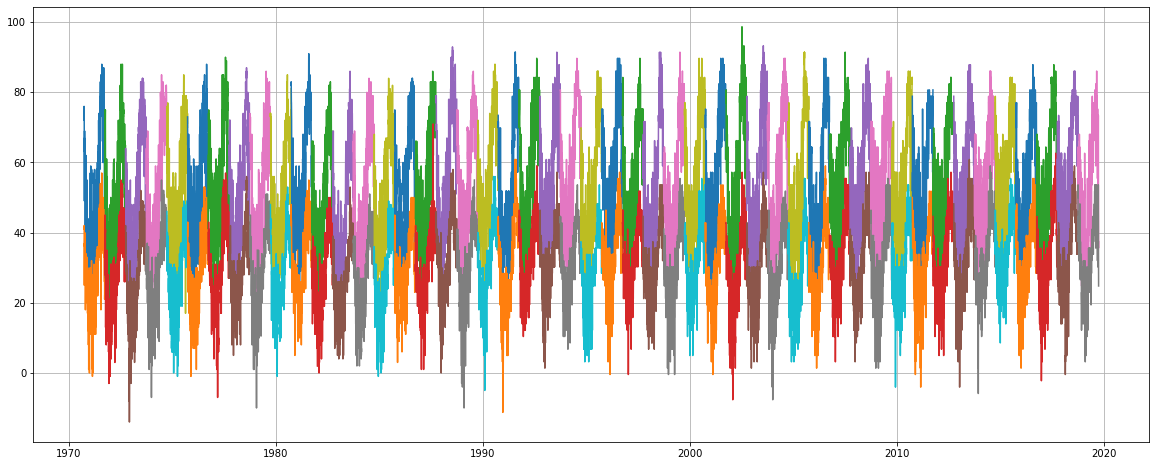

In [47]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):
    plt.plot(cleaned_dfs[i]['date'],cleaned_dfs[i]['air_temp_max_f'],
             cleaned_dfs[i]['date'],cleaned_dfs[i]['air_temp_min_f'])
plt.grid()

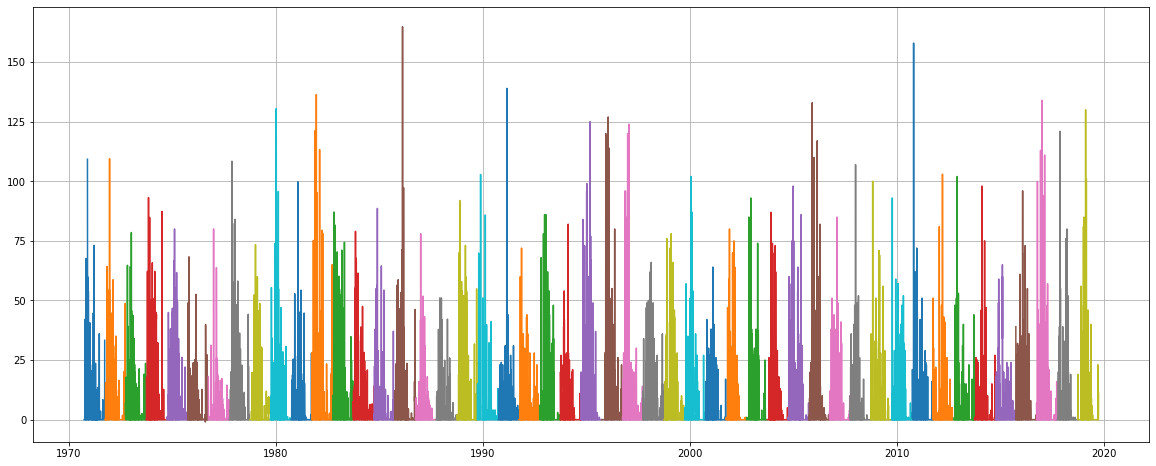

In [48]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):
    plt.plot(cleaned_dfs[i]['date'],cleaned_dfs[i]['total_precip_mm'])
plt.grid()

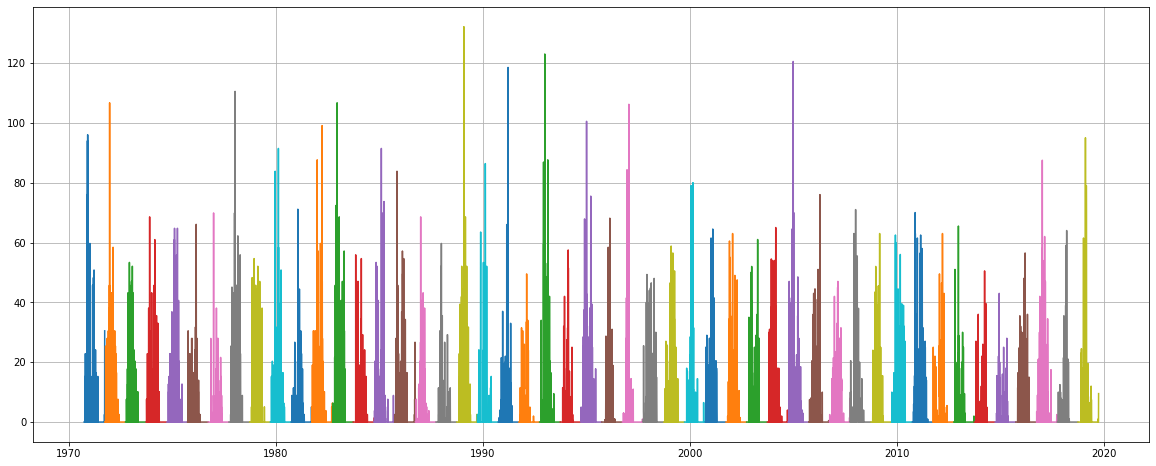

In [49]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):
    plt.plot(cleaned_dfs[i]['date'],cleaned_dfs[i]['new_snow_cm'])
plt.grid()

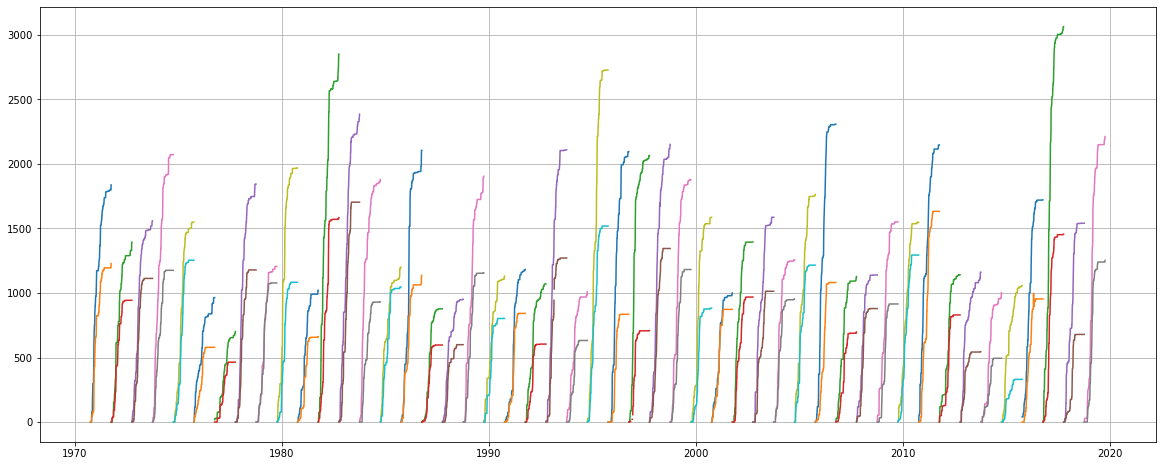

In [50]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):
    plt.plot(cleaned_dfs[i]['date'],cleaned_dfs[i]['season_total_precip_mm'],
             cleaned_dfs[i]['date'],cleaned_dfs[i]['season_total_snow_cm'])
plt.grid()

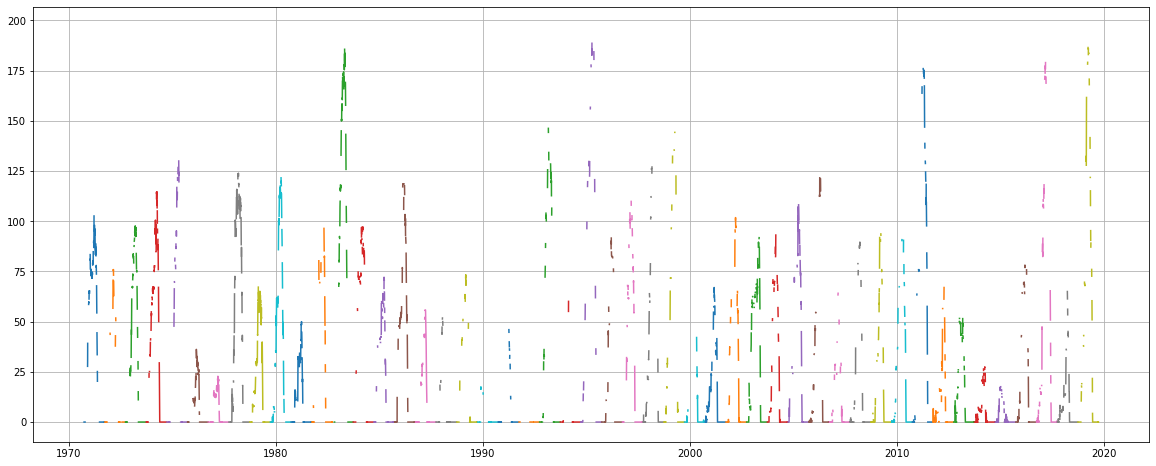

In [51]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):   #
    plt.plot(cleaned_dfs[i]['date'],cleaned_dfs[i]['snow_water_equivalent_cm'])
plt.grid()

In [121]:
cleaned_dfs[0].snow_water_equivalent_cm

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
360    0.0
361    NaN
362    0.0
363    0.0
364    NaN
Name: snow_water_equivalent_cm, Length: 365, dtype: float16

In [75]:
cleaned_dfs[0].date.dt.dayofyear

0      274
1      275
2      276
3      277
4      278
      ... 
360    269
361    270
362    271
363    272
364    273
Name: date, Length: 365, dtype: int64

In [67]:
sys.getsizeof(cleaned_dfs[0].season_total_snow_cm)

3429

In [68]:
sys.getsizeof(cleaned_dfs[0].snow_water_equivalent_cm)

874

C:\Users\oliphaj.TRN\AppData\Local\Temp/ipykernel_23944/2066112254.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_snowpack = pd.concat(cleaned_dfs).groupby('day_of_year').mean().snowpack_depth_cm


Text(0, 0.5, 'Snowpack Depth (cm)')

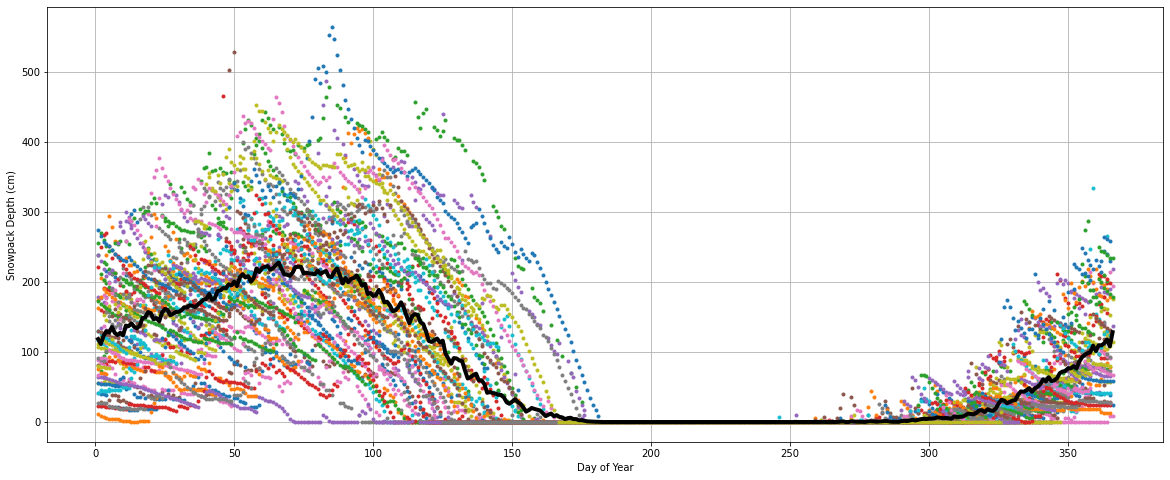

In [118]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):   #
    plt.plot(cleaned_dfs[i]['day_of_year'],cleaned_dfs[i]['snowpack_depth_cm'],'.')
avg_snowpack = pd.concat(cleaned_dfs).groupby('day_of_year').mean().snowpack_depth_cm
plt.plot(np.arange(366)+1,avg_snowpack,'k',lw=4)
plt.grid()
plt.xlabel('Day of Year')
plt.ylabel('Snowpack Depth (cm)')

C:\Users\oliphaj.TRN\AppData\Local\Temp/ipykernel_23944/4014291627.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_temp = pd.concat(cleaned_dfs).groupby('day_of_year').mean().air_temp_max_f
C:\Users\oliphaj.TRN\AppData\Local\Temp/ipykernel_23944/4014291627.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_temp = pd.concat(cleaned_dfs).groupby('day_of_year').mean().air_temp_min_f


Text(0, 0.5, 'Min-Max Temp (F)')

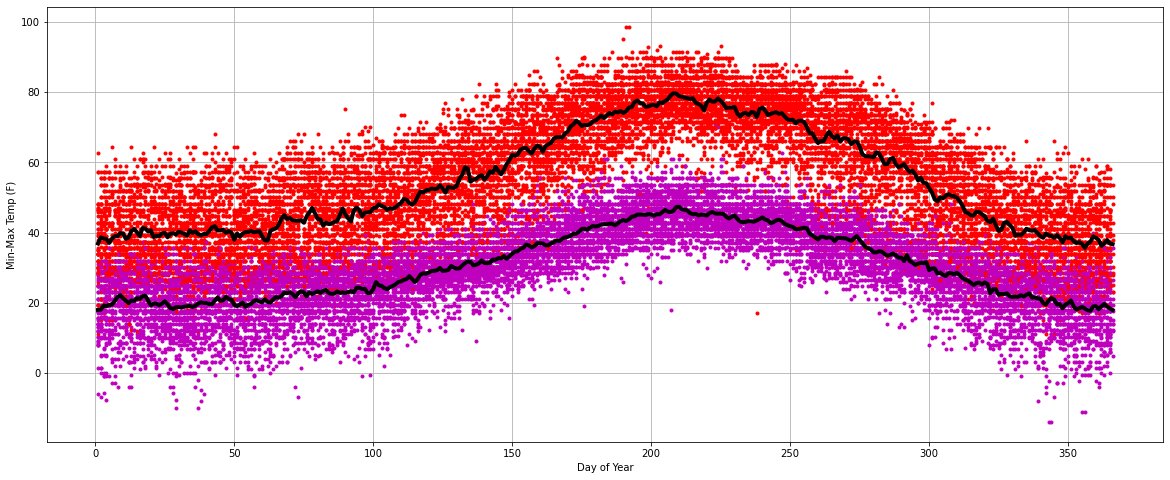

In [120]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):   #
    plt.plot(cleaned_dfs[i]['day_of_year'],cleaned_dfs[i]['air_temp_max_f'],'r.')
    plt.plot(cleaned_dfs[i]['day_of_year'],cleaned_dfs[i]['air_temp_min_f'],'m.')
avg_temp = pd.concat(cleaned_dfs).groupby('day_of_year').mean().air_temp_max_f
plt.plot(np.arange(366)+1,avg_temp,'k',lw=4)
avg_temp = pd.concat(cleaned_dfs).groupby('day_of_year').mean().air_temp_min_f
plt.plot(np.arange(366)+1,avg_temp,'k',lw=4)
plt.grid()
plt.xlabel('Day of Year')
plt.ylabel('Min-Max Temp (F)')

C:\Users\oliphaj.TRN\AppData\Local\Temp/ipykernel_23944/502375095.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_precip = pd.concat(cleaned_dfs).groupby('day_of_year').mean().total_precip_mm


Text(0, 0.5, 'Total Precipitation (mm)')

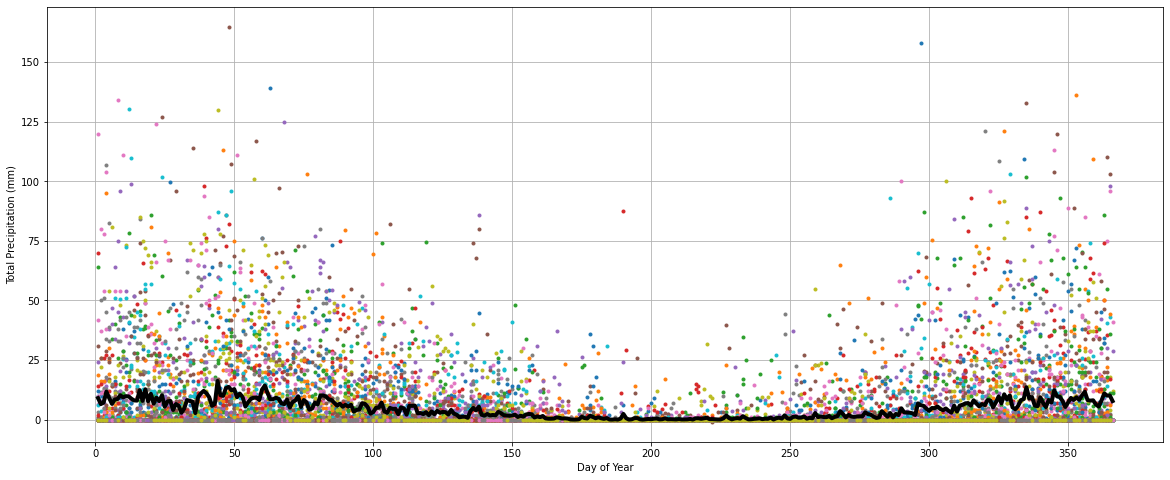

In [108]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):   #
    plt.plot(cleaned_dfs[i]['day_of_year'],cleaned_dfs[i]['total_precip_mm'],'.')
avg_precip = pd.concat(cleaned_dfs).groupby('day_of_year').mean().total_precip_mm
plt.plot(np.arange(366)+1,avg_precip,'k',lw=4)
plt.grid()
plt.xlabel('Day of Year')
plt.ylabel('Total Precipitation (mm)')

C:\Users\oliphaj.TRN\AppData\Local\Temp/ipykernel_23944/3631322590.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_seasontotal = pd.concat(cleaned_dfs).groupby('day_of_year').mean().season_total_snow_cm


Text(0, 0.5, 'Season Total Snow (cm)')

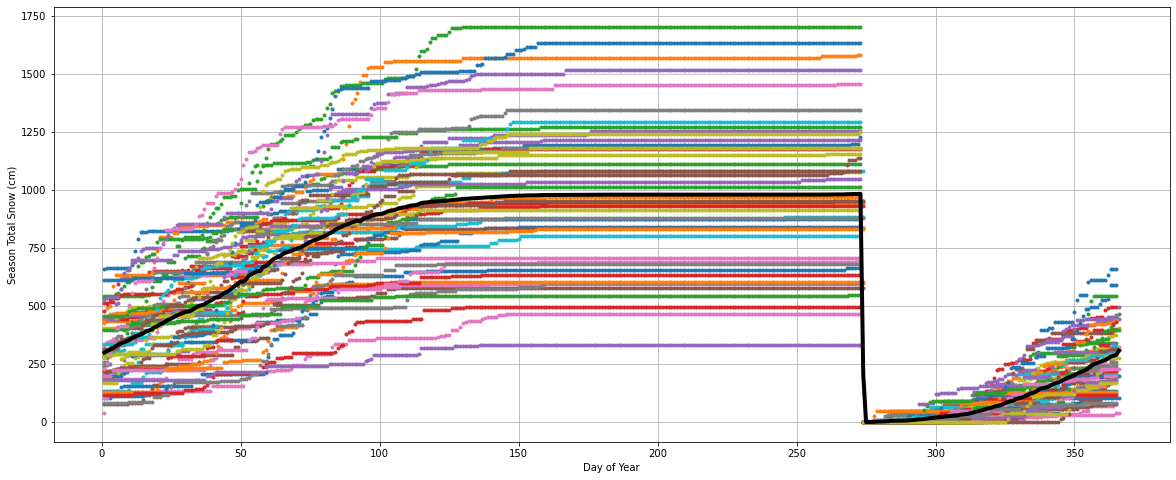

In [110]:
fig = plt.figure(figsize=(20,8))
for i in range(len(dfs)):   #
    plt.plot(cleaned_dfs[i]['day_of_year'],cleaned_dfs[i]['season_total_snow_cm'],'.')
avg_seasontotal = pd.concat(cleaned_dfs).groupby('day_of_year').mean().season_total_snow_cm
plt.plot(np.arange(366)+1,avg_seasontotal,'k',lw=4)
plt.grid()
plt.xlabel('Day of Year')
plt.ylabel('Season Total Snow (cm)')

In [123]:
pd.concat(cleaned_dfs).groupby('day_of_year').mean()

C:\Users\oliphaj.TRN\AppData\Local\Temp/ipykernel_23944/2927887028.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd.concat(cleaned_dfs).groupby('day_of_year').mean()


,total_precip_mm,season_total_precip_mm,new_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,air_temp_max_f,air_temp_min_f,season_total_snow_cm
day_of_year,,,,,,,,
1,9.055118,564.040833,5.371513,118.530136,15.687500,36.905598,17.991072,298.942596
2,6.508909,570.556152,6.888076,111.593750,32.724998,38.634247,18.085459,305.831635
3,7.151587,577.711731,5.969488,123.324402,36.278530,38.333225,19.191008,311.801025
4,11.751716,589.446411,6.985193,129.770599,37.890022,38.152740,19.087372,318.790802
5,9.044045,598.497437,7.854687,127.930290,34.498924,37.088329,19.404337,326.636475
...,...,...,...,...,...,...,...,...
362,7.980927,521.849487,5.730050,109.530472,29.219376,36.220665,19.018814,273.050049
363,11.022391,532.880127,8.577449,112.677086,33.479492,36.932079,19.663584,281.631683
364,10.075456,542.977051,3.483540,118.139862,35.122955,37.876595,18.948980,285.116394


In [158]:
finaldata = (
    pd.concat(cleaned_dfs)
    .dropna(axis=0)
    #.drop(['season_total_precip_mm','season_total_snow_cm'],axis=1)
)
finaldata

,date,total_precip_mm,season_total_precip_mm,new_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,air_temp_max_f,air_temp_min_f,season_total_snow_cm,day_of_year
0,1970-10-01,0.0,0.0,0.0,0.0,0.0,72.00000,41.000000,0.0,274
1,1970-10-02,0.0,0.0,0.0,0.0,0.0,75.93750,41.000000,0.0,275
2,1970-10-03,0.0,0.0,0.0,0.0,0.0,73.93750,42.000000,0.0,276
3,1970-10-04,0.0,0.0,0.0,0.0,0.0,72.93750,38.000000,0.0,277
4,1970-10-05,0.0,0.0,0.0,0.0,0.0,62.96875,38.000000,0.0,278
...,...,...,...,...,...,...,...,...,...,...
359,2019-09-25,0.0,2188.0,0.0,0.0,0.0,73.37500,53.593750,1240.0,268
360,2019-09-26,0.0,2188.0,0.0,0.0,0.0,73.37500,46.406250,1240.0,269
361,2019-09-27,0.0,2188.0,0.0,0.0,0.0,64.37500,44.593750,1240.0,270
362,2019-09-28,9.0,2196.0,0.0,0.0,0.0,46.40625,26.593750,1240.0,271


In [167]:
X = finaldata.drop(['date','day_of_year'],axis=1)
y = finaldata['day_of_year']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train

,total_precip_mm,season_total_precip_mm,new_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,air_temp_max_f,air_temp_min_f,season_total_snow_cm
320,0.0,1047.0,0.0,0.0,0.000000,82.37500,46.406250,330.5
297,0.0,1788.0,0.0,0.0,0.000000,78.93750,48.000000,1195.0
311,0.0,1490.0,0.0,0.0,0.000000,78.93750,41.000000,1113.0
19,20.0,26.0,10.0,10.0,1.599609,37.40625,24.796875,10.0
7,0.0,2.0,0.0,0.0,0.000000,69.81250,37.406250,0.0
...,...,...,...,...,...,...,...,...
274,0.0,1080.0,0.0,0.0,0.000000,87.81250,60.812500,542.5
259,0.0,1243.0,0.0,0.0,0.000000,80.62500,48.187500,948.0
98,0.0,752.0,0.0,153.5,50.093750,35.59375,23.000000,399.0
318,0.0,1538.0,0.0,0.0,0.000000,75.18750,46.406250,1294.0


In [173]:
#regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
#regr.fit(X, y)

scaler = StandardScaler()
scaler.fit(X,y)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

array([[ 6.390e-02,  0.000e+00, -2.505e-01, ..., -7.178e-01, -2.534e-01,
         0.000e+00],
       [ 1.776e+00,  0.000e+00,  3.393e+00, ..., -1.569e+00, -1.640e+00,
         0.000e+00],
       [-2.947e-01, -0.000e+00, -2.505e-01, ...,  7.808e-01,  1.114e+00,
         0.000e+00],
       ...,
       [-2.947e-01, -0.000e+00, -2.505e-01, ...,  4.836e-01,  4.934e-01,
        -0.000e+00],
       [-2.947e-01, -0.000e+00, -2.505e-01, ...,  1.352e-03, -2.534e-01,
        -0.000e+00],
       [-2.947e-01, -0.000e+00, -2.505e-01, ..., -1.198e+00, -2.348e+00,
         0.000e+00]], dtype=float16)

In [175]:
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))
y_pred = regr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

0.32012471247920815
75.64832777526806
0.32012471247920815


In [174]:
rfr = RandomForestRegressor()
  
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))
y_pred = rfr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

0.4080921622787663
70.5848912424203
0.4080921622787663


In [176]:
svm = SVR(C=1.0, epsilon=0.2)
  
svm.fit(X_train, y_train)
print(svm.score(X_test, y_test))
y_pred = svm.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

0.36722132838316346
72.98113626787534
0.36722132838316346


In [162]:
y_pred = rfr.predict(X_test)
rfr_results = pd.DataFrame(y_test)
rfr_results['rfr'] = y_pred
rfr_results

,day_of_year,rfr
272,181,213.644595
182,91,93.740000
361,270,262.875548
220,129,135.790000
120,29,28.570000
...,...,...
8,283,278.337714
245,154,156.350000
276,185,184.850000
264,173,213.740000


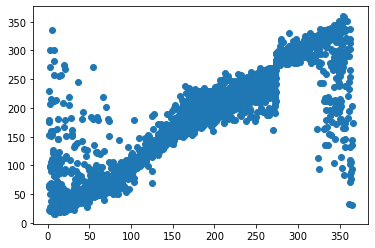

In [163]:
plt.plot(rfr_results.day_of_year,rfr_results.rfr,'o')